# Extracting data - Using Abfun and a *.abf file
# Mildred A. Herrera, Wojciech Ambrosiak
# Jan Siemens lab
# University of Heidelberg

In [1]:
from abfun import *
import timeit
# In case you need to time a cell, just add the following code:
# timeit.timeit()
from matplotlib.pyplot import cm
import os
import matplotlib.colors as mcolors



# Notes:
This file was used to generate habituated cell files, 
I only replaced the fullpath manually to each one of the files and ran it several times.
This cannot be automatic, since you have to select your desired temperature range.
<br>
<br>
Pay attention to the range that you require:
First have a look in the range temperature plot and then when extracting all the variables:
remember c1 is cold, c2 warm, c3 hot temperatures.
For voltage:
V1 = v[idx_c2_start[0]:idx_c2_end[0]], replace the 0 with the position that you prefer
For time:
T1 = t[idx_c2_start[0]:idx_c2_end[0]], 
<br>
<br>
In both files I changed the following:
<br>
no_channels = [0,2] instead of [0,1] as temperature was located differently.
lim_l = 600; lim_r = 600 check the phase plots, limits overall. These limits were the best compromise for both.
<br>
<br>
<br>
Changes for specific habituated files (I always used the first range after a cold pulse).
<br>
habituated/624-3.abf - z1_min_length = 50, 
<br>
habituated/624-12.abf - z1_min_length = 50, temperature range was also short for 50s window_raster, so I used 30.
<br>
habituated/624-7.abf - z1_min_length = 280 - Lost 10 APs of 1162, only 1152 detected. 
<br>
habituated/623-13.abf - z1_min_length = 50
<br>
habituated/622-12.abf - z1_min_length = 100, lim_l = 500, lim_r = 400, had to use the first temperature.

In [2]:
# Part One:
# I. Extracting data

# Step 1: Add a variable with the name of the file:

fullpath = '...exampl/habituated/622-12.abf' #<---- Change here!!
filename = os.path.basename(fullpath)
name = os.path.splitext(filename)[0]
path = os.path.dirname(fullpath)
# Step 1: Define the sweep and the number of channels present in the recording:

sweep = 0 # User defined

no_channels = [0, 2]

t, v, c = abf_me(fullpath, sweep, no_channels) # Function inside abfun

# t - Time
# v - Voltage
# c - Temperature

#test that it worked:
print('At position 20, in cell', name,':', 'the voltage is', v[100000],'mV', 'at', t[100000], 's with a temperature of', c[100000])

# This cell takes: 0.006716431002132595 s
# timeit.timeit()

# Troubleshooting: no_channels = [0, 1] if temperature is located differently

At position 20, in cell 622-12 : the voltage is -41.20875 mV at 5.0 s with a temperature of 36.01634


In [3]:
# II Temperature:

# bins_c = Temperature steps [0, series of meaningful steps, superior limit]
bins_c = [0,32.5,33.5,35.5,36.5,38.5,39.5]

# Names of the ranges: Includes ranges of interest and non-interest possible within bins_c.
names = ['<32.5', '32.5-33.5', '33.5-35.5', '35.5-36.5', '36.5-38.5', '38.5-39.5']

# Gives an index to each name of the ranges. Ex. 1: '<32.5', 2: '32.5-33.5'...
d = dict(enumerate(names, 1))

# Classifies the temperature into bins.
c_groups = np.vectorize(d.get)(np.digitize(c, (bins_c)))
# The np.digitize will take the temperature and find the bin that contains it.
# The np.vectorize will get the range based on the names of the classification
# and that is the output of c_groups.

# Because we also need to check if the classification was working. I made this list:

# tagged_c = A list containing [temperature, classification]
tagged_c = [c, c_groups]

# Test it:
#print(d)
#print(len(c)/2)
#print(c[6405120])
#print(c_groups[6405120])

In [4]:
# III. Ranges of interest and testing that the ranges are working:

# np.hstack only shapes the output, to make it row-wise.
# for np.arrays, np.where is needed. This is similar to a find. 
# So basically:

# c_1 = Make a row of positions where the bin was '32.5-33.5'
c_1 = np.hstack(np.where(tagged_c[1] == '32.5-33.5')) 
c_2 = np.hstack(np.where(tagged_c[1] == '35.5-36.5')) 
c_3 = np.hstack(np.where(tagged_c[1] == '38.5-39.5')) 


In [5]:
# Test the first 100 positions:
c[c_2[0:100]]


array([35.9247, 35.9247, 35.9308, ..., 35.9249, 35.9219, 35.9249],
      dtype=float32)

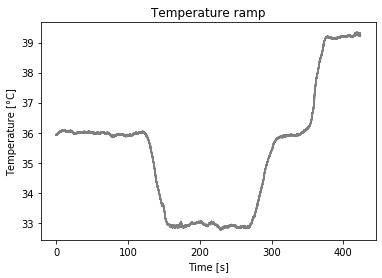

In [6]:
# I would always plot the whole temperature just to see how it looks like:
# you can prettify this later:
plt.title('Temperature ramp')
plt.plot(t,c, 'k', alpha = 0.5) # alpha makes lines "transparent", from black to grey in this example.
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.show()


In [7]:
## IV. Getting the beginning and end positions of each temperature change.
# Assuming the minimum length of a range of temperature is:
min_window = 30 # seconds

# Taking into consideration the sampling_rate:
sampling_rate = 20000

# This function takes the temperature, a group of positions of x temp and the sampling rate.
def binbytemp(c, c_x, window, sampling_rate):
    cx_st_end = cstartend(c, c_x)
    cx_lenpeak= peaklen(cx_st_end)
    min_length_c = window * sampling_rate
    idx_cx_start, idx_cx_end = idx_peaks_startend(cx_st_end,cx_lenpeak,min_length_c)
    cx_vec, cx_id = peaksy(idx_cx_start, idx_cx_end)
    return [idx_cx_start, idx_cx_end]


# We use the function defined above:
# get index c1 start and the index c1 end, based on the bins and longer than x window.
[idx_c1_start, idx_c1_end] = binbytemp(c, c_1, min_window, sampling_rate)
[idx_c2_start, idx_c2_end] = binbytemp(c, c_2, min_window, sampling_rate)
[idx_c3_start, idx_c3_end] = binbytemp(c, c_3, min_window, sampling_rate)

# This cell takes: 0.008622665074653924 s to execute.



In [8]:
# In case you had several temperature changes of a considerable length. 
# It is convenient to find their position.
# the \ works like an enter, but keeps running the code.
# I use it to keep the code visible:
# the / works as a mathematical operation (division).

print("Temperature range" , names[1] , "has", len(idx_c1_start), \
      "continous group/s detected:")
for ii in range(0, len(idx_c1_start)):
    print("Group", ii + 1, "Position:",idx_c1_end[ii], "With a length of",\
          idx_c1_end[ii] - idx_c1_start[ii], "Datapoints", "s:",\
          (idx_c1_end[ii] - idx_c1_start[ii]) / (sampling_rate))
print("")
print("Temperature range" , names[3] , "has", len(idx_c2_start), \
      "continous group/s detected:")

for ii in range(0, len(idx_c2_start)):
    print("Group", ii + 1, "Position:",idx_c2_end[ii], "With a length of",\
          idx_c2_end[ii] - idx_c2_start[ii], "Datapoints", "s:",\
          (idx_c2_end[ii] - idx_c2_start[ii]) / (sampling_rate))
print("")
print("Temperature range" , names[5] , "has", len(idx_c3_start), \
      "continous group/s detected:")

for ii in range(0, len(idx_c3_start)):
    print("Group", ii + 1, "Position:",idx_c3_end[ii], "With a length of",\
          idx_c3_end[ii] - idx_c3_start[ii], "Datapoints", "s",\
          (idx_c3_end[ii] - idx_c3_start[ii]) / (sampling_rate))


Temperature range 32.5-33.5 has 1 continous group/s detected:
Group 1 Position: 5583795 With a length of 2577774 Datapoints s: 128.8887

Temperature range 35.5-36.5 has 2 continous group/s detected:
Group 1 Position: 2624316 With a length of 2624316 Datapoints s: 131.2158
Group 2 Position: 7122257 With a length of 1080418 Datapoints s: 54.0209

Temperature range 38.5-39.5 has 1 continous group/s detected:
Group 1 Position: 8474624 With a length of 1105045 Datapoints s 55.25225


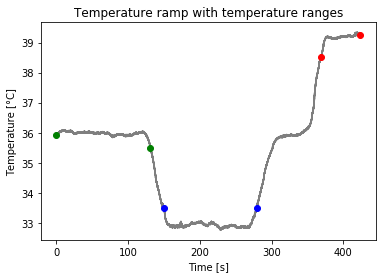

In [9]:
# I would also plot the ranges on top of the temperature:

plt.plot(t,c, 'k', alpha = 0.5) # alpha makes lines "transparent", from black to grey in this example.

# First temperature of interest:
plt.plot(t[idx_c1_start[0]],c[idx_c1_start[0]], 'bo')
plt.plot(t[idx_c1_end[0]],c[idx_c1_end[0]], 'bo')

# Second:
plt.plot(t[idx_c2_start[0]],c[idx_c2_start[0]], 'go')
plt.plot(t[idx_c2_end[0]],c[idx_c2_end[0]], 'go')

# Third:
plt.plot(t[idx_c3_start[0]],c[idx_c3_start[0]], 'ro')
plt.plot(t[idx_c3_end[0]-1],c[idx_c3_end[0]-1], 'ro')

plt.title('Temperature ramp with temperature ranges')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.show()

plt.show()

#Troubleshooting: 
# Not showing the range you want? check the position that you want to show. ex. idx_c2_start[1] instead of [0]
# INDEX OUT OF BOUNDS??, means the last datapoint of the range is missing. Check with color dot is missing:
# Adjust by:
# t[idx_cx_end[0]-1],c[idx_cx_end[0]-1]
# If you forgot to change this, it will only remove one datapoint from the third vector, so no big deal.

# Extracting peaks

In [10]:
# I. Working with voltage and time:

# Now the signal of interest is within the next limits:
# For voltage:
V1 = v[idx_c2_start[0]:idx_c2_end[0]] # <----- MODIFY HERE!!!!
# For time:
T1 = t[idx_c2_start[0]:idx_c2_end[0]] # <----- MODIFY HERE!!!!

In [11]:
# II. Baseline correction : Slow.
# Don't change these:
lam = 10**2;p = 0.01;niter = 10 
# For this dataset these were the values that worked the best

z1 = np.array(baseline_als(V1, lam, p, niter)) # z is v corrected.
# This cell takes: 0.012812254019081593 s to execute.


In [29]:
# III. Using functions defined in abfun to extract the peaks and other info:

# the threshold in this case, only says that there are no valleys bigger than -30.
thr = -30 # <----- You might have to adjust this, if error when plotting ***

z1_valleys = valleyser(z1, T1, thr); # Comment only if the frequency list is almost EMPTY and use next lines:
#from scipy.signal import find_peaks
#z1_valleys, properties = find_peaks(z1, prominence=(None, 0.6))


# Getting the start and end positions and the whole vec.
z1_peaks_st_end = peakstartend(z1, z1_valleys);
z1_lenpeak = peaklen(z1_peaks_st_end);

# Defining the minimum lenght of a spike/peak.
z1_min_length = 100 #<------You might have to adjust this, if error when plotting ***
# from 50 to 400, multiple of 10.

z1_idx_peak_start, z1_idx_peak_end = idx_peaks_startend(z1_peaks_st_end,z1_lenpeak,z1_min_length);

# Getting the peaks:
z1_peaks_vec, z1_peaks = peaksy(z1_idx_peak_start, z1_idx_peak_end);

In [30]:
# Don't change these, unless last resort! If you change them, check the frequency list (next cell)
z1_change_l = 30 # Normal 30
z1_change_r = 40 # Normal 40
z1_total_change = 3
z1_peaktop_id, z1_peaktop_v, z1_peaktop_t = peaktop(z1_peaks_vec, z1, T1, thr, z1_change_l, z1_change_r, z1_total_change)

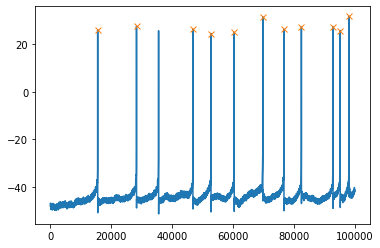

In [31]:
# Check that the peaks are correctly estimated, and if some are missing modify: z1_min_length to a different range.
first_vals = z1[0:100000]
first_peaks = sorted(i for i in z1_peaktop_id[0:100] if i <= 100000)
plt.plot(first_vals)
plt.plot(first_peaks, first_vals[first_peaks], "x")
plt.show()
# Debug: 
# Check if the peaks with x correspond to the peaks in the first 10000 datapoints.
# If not: Check the thr and modify the z1_min_length. 

# Plotting

In [32]:
# I. Extracting the frequency of spikes in windows of given x seconds.
window = 20 # shorter windows give false endpoints.
# Default 20 s

z1_list_peaks = freqx2(t,T1,z1,z1_peaktop_id,sampling_rate,window)
z1_freq_list = []
for ii in range(len(z1_list_peaks)):
    z1_freq_list.append(len(z1_list_peaks[ii]))
print('This temperature range has', len(z1_freq_list), 'chunks of', window, 'seconds.')
print('The frequency of each window is:',z1_freq_list)

# Comment the next lines if you don't want to save it:
# Saving this information in a file:
freq_filename = str(name)+'_freq.txt'
freq_path = os.path.join(path,freq_filename)
with open(freq_path, 'w') as f:
    for item in z1_freq_list:
        f.write("%s\n" % item)
print('Frequency list saved in file:' + freq_path)
print(('No of APs: '+ str(np.sum(z1_freq_list))))

This temperature range has 7 chunks of 20 seconds.
The frequency of each window is: [74, 126, 195, 292, 355, 352, 192]
Frequency list saved in file:/home/milk/Documents/Siemens/abf_woj1/exampl/habituated/622-12_freq.txt
No of APs: 1586


In [33]:
# # Just to depict the cumulative frequency - SLOW:
# plt.plot(np.cumsum(z1_freq_list[0:-1]))
# # Do not use the last one for cumulative frequency.
#plt.show()
#z1_list_peaks[0]


In [34]:
# II. AP Waveforms and means of 20s.

In [36]:
# Setting limits for the windows of the APs: 
lim_l = 500; lim_r = 400; # <------If firing rate is fast, you might have to modify this 500-1000, div by 50.
# Default 600.

sZ1 = []; sT1 = []; mZ1 = []
time_peak = []
#list_peaks comes from def xpex

# Ignoring the very first peak:
z1_list_peaks[0] = np.delete(z1_list_peaks[0],0)

for ii in range(0, len(z1_list_peaks)):
    sZ1.append(xpex(z1,t,z1_list_peaks[ii],lim_l,lim_r, var = 'signal'))
    sT1.append(xpex(z1,t,z1_list_peaks[ii],lim_l,lim_r, var = 'time'))
    mZ1.append(xpex(z1,t,z1_list_peaks[ii],lim_l,lim_r, var = 'mean'))
    
#sZ=np.array([np.array(ii) for ii in sZ])
total_no_spikes = sum(len(x) for x in sZ1)
print('The total number of spikes in all chunks is:', total_no_spikes, 'APs')

# DEBUG:
# You get an error??:
# ValueError: operands could not be broadcast together with shapes .... 
# Check how fast it is spiking in datapoints:
# z1_list_peaks[0] # Just the first chunk of 20 s
# ISP = np.diff(z1_list_peaks[0])
# If the results are smaller than the sum of both lims, it is not possible to extract those APs.
# Make lim_l and lim_r smaller to 100 for example, and check if it works, then enlarge it until no error.
# Debug in part III of Extracting peaks. 
# z1_min_length = start with 400 and go to 300,200,100, until 50, any number multiple of 10.


The total number of spikes in all chunks is: 1584 APs


In [37]:
# UNCOMMENT IF CURIOUS:

In [38]:
## Plotting the APs:
#color1=iter(cm.cool(np.linspace(0,1,len(sZ1[1]))))
#
##Plotting all APs in x group of chunks:
#plt.title("first" + str(window) + "seconds")
#for ii in range(0,(len(sZ1[1]))): #<----Change 1 to another number to see another group. 
#    c1=next(color1)
#    plt.plot(sZ1[1][ii], alpha = 0.5, c=c1) #only first window 
#plt.show()
#
##Plotting mean APs in each chunk:
#color=iter(cm.cool(np.linspace(0,1,len(mZ1))))
#plt.title("Mean of each " + str(window) + " seconds window")
#for ii in range(0,len(mZ1)):
#    c=next(color)
#    plt.plot(mZ1[ii], c=c, linestyle=':') #only means of all windows
#plt.show()
#
## Debug:
## You probably only have 1 to 2 chunks of 20 s[0 or 1], do not go to 2.

In [39]:
# III. Waveform analysis to determine the minimum deflections in the signal, don't change these parameters:
# Don't change these (ask me first):

chunk_size = 50 # Lim_r + Lim_l should be divisible by this number. 
# E.g. 50 for 120 will raise an error, contrary to 150.
z1_pol_vals = []
z1_template = []
savgol_window = 101 # Needs to finish with 1.
savgol_polynomial = 1 # first order polynomial
#temp_site, max_change = peakbase(peaktop_id, z, t, savgol_window, savgol_polynomial)
# Result should be a pyramid. If the sides do not reach the base, lim_r or lim_r should be longer.
# Second image sides should reach 1.

for ii in range(0, len(mZ1)):
    z1_pol_vals.append(peakbase(mZ1[ii], t, chunk_size, savgol_window, savgol_polynomial, var = 'peakchange1'))
    
    
for ii in range(0, len(mZ1)):
    z1_template.append(peakbase(mZ1[ii], t, chunk_size, savgol_window, savgol_polynomial, var = 'peakchange2'))


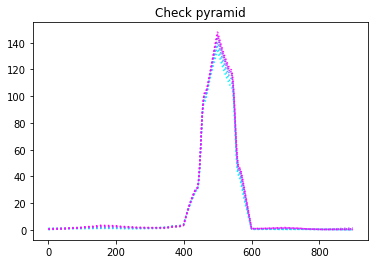

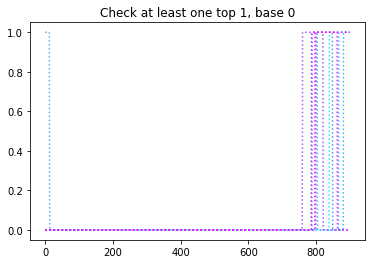

In [40]:
# Plotting all mean APs in all bins of X seconds:
color=iter(cm.cool(np.linspace(0,1,len(z1_pol_vals))))
plt.title('Check pyramid')
for ii in range(0,len(z1_pol_vals)):
    c=next(color)
    plt.plot(z1_pol_vals[ii], c=c, linestyle=':') #only means of all windows
plt.show()

color=iter(cm.cool(np.linspace(0,1,len(z1_pol_vals))))
plt.title('Check at least one top 1, base 0')
for ii in range(0,len(z1_pol_vals)):
    c=next(color)
    plt.plot(z1_template[ii], c=c, linestyle=':') #only means of all windows
plt.show()

# Troubleshooting: Pay attention that in the first plot there is only one pyramid in the center.
# And in the second that there is at least one square.

In [41]:
# Checking where the minimum deflections start (not threshold) (red and green dot in the next plot)
z1_base_id = []

for ii in range(0, len(z1_template)):
    z1_base_id.append(basepoints(z1_template[ii]))
    
print(z1_base_id)
print('Check if you have several initial zeros [0,number], if true you might have to enlarge the lim_l or lim_r.')

[[0, 838], [0, 866], [13, 799], [0, 785], [0, 759], [0, 787], [0, 796]]
Check if you have several initial zeros [0,number], if true you might have to enlarge the lim_l or lim_r.


-35.25290452310573
900
900
-39.565519478176654
400 0.0305 3 613


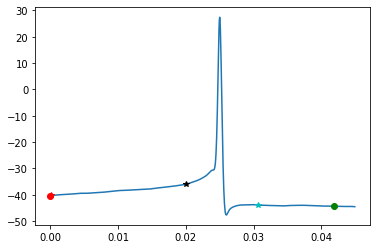

In [42]:
# AP mean of only one chunk:

z1_mean_peaktop_id, z1_duration, z1_hpoint_1, z1_hpoint_2 = peakdur(mZ1[1], t, sampling_rate, lim_r, lim_l, z1_base_id[0][1]);

print(z1_mean_peaktop_id, abs(z1_duration), z1_hpoint_1, z1_hpoint_2)
sTW = t[0:(lim_r + lim_l)]
mZW = mZ1[0] # <----Chunk selected:
bZW_ini = z1_base_id[0][0] # <----If you select chunk 1 instead change [0][0] to [1][0]
bZW_end = z1_base_id[0][1] # <----If you select chunk 1 instead change [0][1] to [1][1]
plt.plot(sTW, mZW)
#plt.plot(sTW[baseline_l_id], mZ0[baseline_l_id], 'bo')
plt.plot(sTW[bZW_ini], mZW[bZW_ini], 'ro')
plt.plot(sTW[bZW_end], mZW[bZW_end], 'go')
plt.plot(sTW[z1_mean_peaktop_id], mZW[z1_mean_peaktop_id], 'k*')
plt.plot(sTW[z1_hpoint_1], mZW[z1_hpoint_1], 'r*')
plt.plot(sTW[z1_hpoint_2], mZW[z1_hpoint_2], 'c*')

plt.show()

# The position of the red dot is the minimum required lim_l, similarly, the green one for the lim_r.
# This matters for the phase plots.

-36.00346888684449
900
900
-40.19139925418601
-35.25290452310573
900
900
-39.65468970800862
-34.5717143641849
900
900
-38.817013719555426
-33.48033157385873
900
900
-37.71158915117549
-32.715185185561275
900
900
-37.040608516060885
-32.495838300624705
900
900
-37.04433880029109
-32.55027037496285
900
900
-37.39620900055671


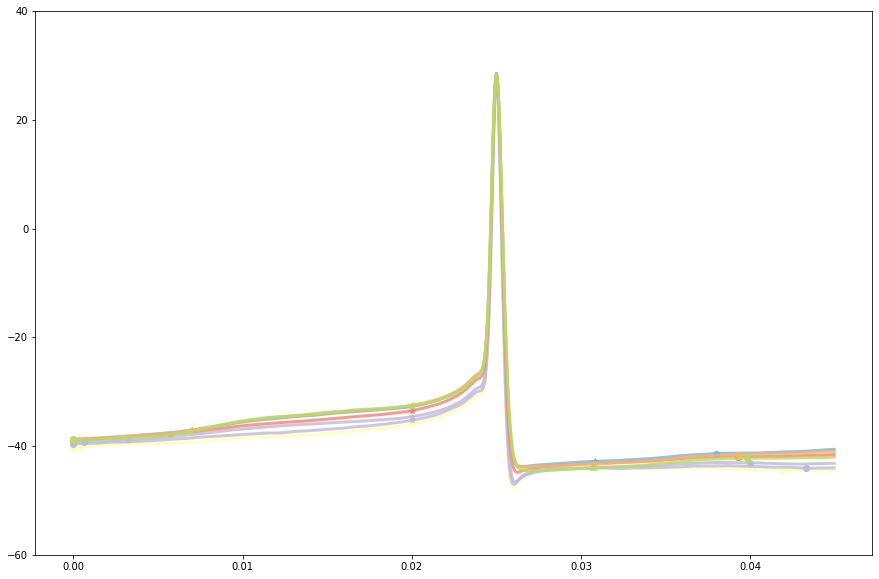

In [43]:
# Same as above, but the mean of all chunks of X s.

sTW = t[0:(lim_r + lim_l)]

all_mZW = {}
all_bZW_ini = []
all_bZW_end = []
all_z1_mean_peaktop_id = {}
all_z1_duration = {}
all_z1_hpoint_1 = {}
all_z1_hpoint_2 = {}
fig = plt.figure(figsize= (15,10))

n = len(mZ1)
m_cmap = plt.cm.Set3(np.linspace(.1,.5,n))

plt.ylim([-60,40])
for ii in range(len(mZ1)):
    all_mZW[ii] = mZ1[ii]
    all_z1_mean_peaktop_id[ii], all_z1_duration[ii], all_z1_hpoint_1[ii], all_z1_hpoint_2[ii] = peakdur(mZ1[ii], t, sampling_rate, lim_r, lim_l, z1_base_id[ii][1])
    #print(z1_mean_peaktop_id, z1_duration, z1_hpoint_1, z1_hpoint_2)
    all_bZW_ini.append(z1_base_id[ii][0])
    all_bZW_end.append(z1_base_id[ii][1])
    plt.plot(sTW, all_mZW[ii], alpha = 0.8, linewidth= 3, color = m_cmap[ii])
    #plt.plot(sTW[baseline_l_id], mZ0[baseline_l_id], 'bo')
    plt.plot(sTW[all_bZW_ini[ii]], all_mZW[ii][all_bZW_ini[ii]], color = m_cmap[ii], marker = 'o')
    plt.plot(sTW[all_bZW_end[ii]], all_mZW[ii][all_bZW_end[ii]], color = m_cmap[ii], marker = 'o')
    plt.plot(sTW[all_z1_mean_peaktop_id[ii]], all_mZW[ii][all_z1_mean_peaktop_id[ii]], color = m_cmap[ii], marker = '*')
    plt.plot(sTW[all_z1_hpoint_1[ii]], all_mZW[ii][all_z1_hpoint_1[ii]], color = m_cmap[ii], marker = '*')
    plt.plot(sTW[all_z1_hpoint_2[ii]], all_mZW[ii][all_z1_hpoint_2[ii]], color = m_cmap[ii], marker = '*')
plt.show()


In [44]:
#Saving the all the means in 20 seconds to a file:

mean_AP_filename = str(name)+'_mean_AP.csv'
np.savetxt(os.path.join(path,mean_AP_filename), mZ1, delimiter=",")

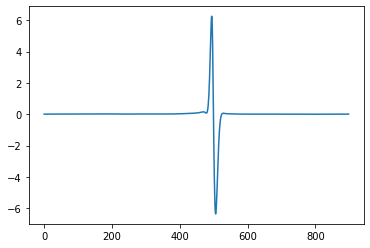

In [45]:
# Same as above, but the mean of all means:

timeVec = sTW = t[0:(lim_r + lim_l)] #same as above
mean_mZW = np.mean(list(all_mZW.values()), axis = 0)
mean_bZW_ini = int(round(np.mean(all_bZW_ini)))
mean_bZW_end = int(round(np.mean(all_bZW_end)))
mean_z1_mean_peaktop_id = int(np.mean(list(all_z1_mean_peaktop_id.values())))
mean_z1_duration = np.mean(list(all_z1_duration.values()))
mean_z1_hpoint_1 = int(round(np.mean(list(all_z1_hpoint_1.values()))))
mean_z1_hpoint_2 = int(round(np.mean(list(all_z1_hpoint_2.values()))))

# Find just the most abrupt change in the derivative (Threshold of the AP)

dy = np.diff(mean_mZW)/1
plt.plot(dy)
plt.show()
mean_peak_start = abs(dy) > 0.2 # <--- You might have to modify this (0.1)
start = np.nonzero(mean_peak_start)
threshold_AP_pos = start[0][0]

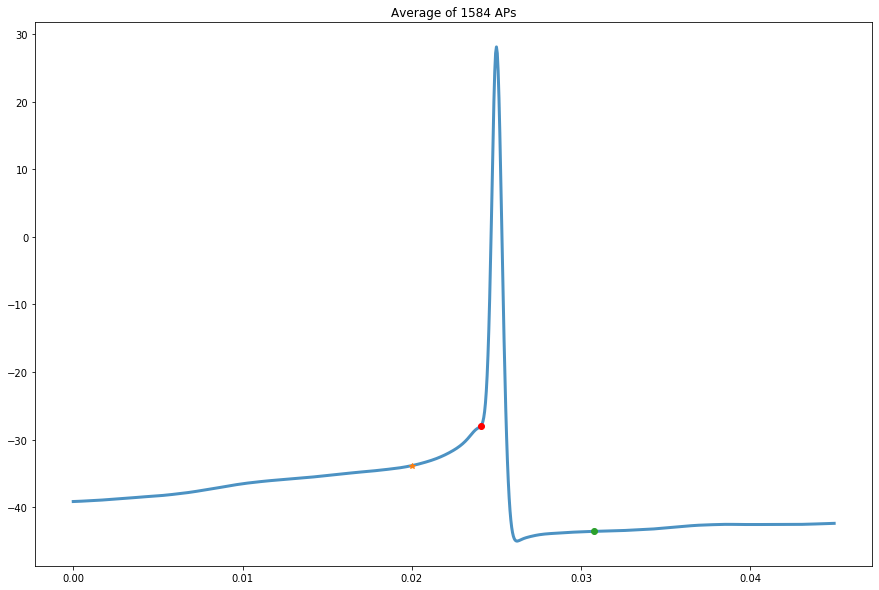

In [46]:
# AP mean of allllll means:

fig = plt.figure(figsize= (15,10))
plt.title('Average of ' + str(total_no_spikes) + ' APs')
plt.plot(sTW, mean_mZW, alpha = 0.8, linewidth= 3)
#plt.plot(sTW[mean_bZW_ini], mean_mZW[mean_bZW_ini], marker = 'o')
#plt.plot(sTW[mean_bZW_end], mean_mZW[mean_bZW_end], marker = 'o')
plt.plot(sTW[mean_z1_mean_peaktop_id], mean_mZW[mean_z1_mean_peaktop_id], marker = '*')
#plt.plot(sTW[mean_z1_hpoint_1], mean_mZW[mean_z1_hpoint_1],  marker = '*')
plt.plot(sTW[mean_z1_hpoint_2], mean_mZW[mean_z1_hpoint_2], marker = 'o')

# Threshold:
plt.plot(sTW[threshold_AP_pos], mean_mZW[threshold_AP_pos], 'ro')
#plt.plot(sTW[start[0][-1]], mean_mZW[start[0][-1]], marker = 'o')
plt.show()

dt is:0.0000500000


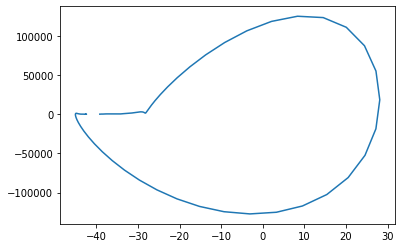

In [47]:
# IV. Phase-plot:

# Here I am having trouble understanding the derivative units, but the plot is what it should be.
dV = np.diff(mean_mZW)
dt = np.diff(timeVec) # or just t[1]

# Correcting vector mismatch for plotting:
dV_dt = (dV/dt)
dV_dt_ = dV_dt
dV_dt_corr = np.insert(dV_dt_,0,dV_dt[0]);
max_dV_dt = np.argmax(dV_dt_corr)

plt.plot(mean_mZW,dV_dt_corr)
#plt.plot(mean_mZW,dV_dt_corr/sampling_rate) <----- TEST this instead.
units_of_derivative = 0.001/0.00005 #(1 mV/in 0.00005 s)
plt.show
print('dt is:'+ '{0:.10f}'.format(t[1]))

In [ ]:
#V - Raster_plot:

window_raster = 20 # seconds
z1_spike_data = raster_vec(z1,t,z1_peaktop_id, sampling_rate, window_raster)

In [ ]:
# Draw a spike raster plot
cNorm  = mcolors.Normalize(vmin=0, vmax=(len(z1_spike_data)))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='Set3')
colorVal = [scalarMap.to_rgba([ii]) for ii in range(0,len(z1_spike_data))]

fig = plt.figure(figsize= (10,2))
yticks = range(len(z1_spike_data))
plt.eventplot(np.flipud(z1_spike_data), color = colorVal) #np.flipud if you want to plot the first windows above.
#plt.eventplot(np.flipud(z1_spike_data), color = 'k')
plt.title('Spike raster plot')
plt.ylabel('window')
plt.xlabel('seconds')
plt.yticks(yticks, yticks[::-1])
plt.show()

In [ ]:
# Saving outputs:

In [48]:
# Saving info of rasterplot, only initial 50 s (although to plot it would be better only 20 s)

window_raster = 50 #<-----temperature range dependent!!! Default 50 s.
spike_data = raster_vec(z1,t,z1_peaktop_id, sampling_rate, window_raster)

raster_filename = str(name)+'_raster.txt'
np.savetxt(os.path.join(path,raster_filename), spike_data[0]) #<--- Just 1st window
    
    #open it with genfromtxt
    
# Debug:
# The temperature is very short, so just get the first seconds.